In [1]:
import torch
import torch.nn as nn 
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
import seaborn as sns
import scipy 

from functools import partial
from tqdm.notebook import tqdm
from sconf import Config

import sys
sys.path.append('..')

from classes import MLP, MultiTaskLoss
from utils import non_markovian_midprice

/Users/nicholasmartin/Programming/Research/optimal-execution-kernel-decomposition/venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
config = Config('config.yaml')

In [3]:
rng = np.random.default_rng(123)

num_paths = config.num_paths
num_timesteps = config.num_timesteps
final_time = config.final_time
initial_price = config.initial_price
decomp_dim = config.decomp_dim
num_episodes = config.num_episodes
batch_size = config.batch_size

dt = final_time/num_timesteps

inital_prices = np.ones((1, num_paths)) * initial_price

permenant_price_impact_func = lambda x: 0.01*x
# kernel_function = lambda x,y: ((np.abs((x-y))+(dt))**(0.51-1))/scipy.special.gamma(0.51)
# kernel_function = lambda x,y: (1/(np.sqrt(2*np.pi)))*np.exp(-(x-y)**2)
kernel_function = lambda x,y: np.exp(-np.abs((x-y)))
K0 = kernel_function(0,0)

nu_vals = rng.uniform(-50, 100,size=(num_timesteps, num_paths))

sigma_true = 0.1

In [29]:
network = MLP(decomp_dim=decomp_dim)
mt_loss = MultiTaskLoss(num_losses=5)
optimizer = torch.optim.Adam(params=[*network.parameters(),
                                     *mt_loss.parameters()],
                             lr=1e-3)

# Generate Data

# NN Approach

In [30]:
batch_size = 64
loss_list = []
for i in tqdm(range(100_000)):

    time_one = torch.FloatTensor(rng.uniform(0, num_timesteps, batch_size)).reshape(-1,1)*dt
    time_two = torch.FloatTensor(rng.uniform(0, num_timesteps, batch_size)).reshape(-1,1)*dt
    K_one_two = network.approx_func(time_one, time_two).flatten()

    true_val = torch.FloatTensor(kernel_function(time_one.detach().numpy(), 
                                                 time_two.detach().numpy())).flatten()

    error = torch.pow(true_val-K_one_two, 2)

    K_one_one = network.approx_func(time_one, time_one).flatten()
    K_two_two = network.approx_func(time_two, time_two).flatten()

    kernel_error_one = torch.pow(K_one_one-torch.FloatTensor([K0]), 2)
    kernel_error_two = torch.pow(K_two_two-torch.FloatTensor([K0]), 2)
    kernel_error_three = torch.pow(K_one_one-K_two_two, 2)

    # Translation Invariance
    delta = torch.FloatTensor(rng.uniform(-num_timesteps,
                                          num_timesteps, 
                                          batch_size)).reshape(-1,1)*dt
    
    time_one_delta = time_one + delta
    time_two_delta = time_two + delta
    K_one_two_delta = network.approx_func(time_one_delta, time_two_delta).flatten()

    kernel_error_four = torch.pow(K_one_two-K_one_two_delta, 2)

    # K_limit = network.approx_func(time_one, torch.FloatTensor([[10*num_timesteps*dt]])).flatten()
    # asymtopic_loss = torch.pow(K_limit-0, 2)

    # # Monotonic Decreasing
    # f_prime_one = torch.vstack([torch.autograd.functional.jacobian(network, 
    #                                                  _, 
    #                                                  create_graph=True).flatten() for _ in time_one])

    # f_t_dot_f_s_prime = (f_prime_one * network(time_two)).sum(dim=-1).flatten()

    # montonic_loss = torch.max(torch.zeros_like(f_t_dot_f_s_prime), -f_t_dot_f_s_prime)

    loss_tensor = torch.hstack([error.mean(), 
                                kernel_error_one.mean(), 
                                kernel_error_two.mean(),
                                kernel_error_three.mean(),
                                kernel_error_four.mean(),
                                # asymtopic_loss.mean(),
                                # montonic_loss.mean()
                                ])

    loss = mt_loss(loss_tensor)

    loss_list.append(loss.detach().item())

    network.zero_grad()
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    network.zero_grad()
    optimizer.zero_grad()

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

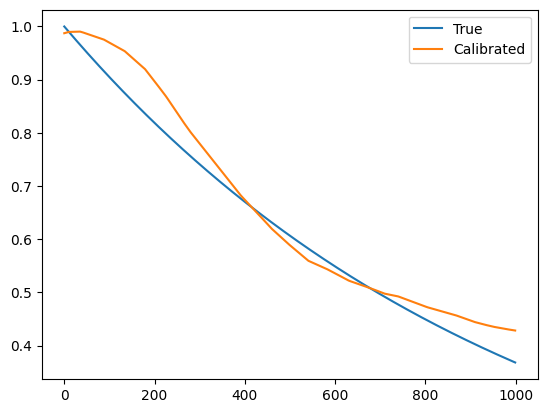

In [31]:
s_val = 0
kernel_plot = []
kernel_plot_two = []

for i in range(0, num_timesteps):
    k_s_t = network.approx_func(torch.FloatTensor([s_val*dt]).reshape(-1,1), torch.FloatTensor([i*dt]).reshape(1,-1))
    kernel_plot.append(k_s_t.detach().item())

partial_func = partial(kernel_function, y=s_val*dt)
for i in range(0, num_timesteps):
    val = partial_func(i*dt)
    kernel_plot_two.append(val)

plt.plot(kernel_plot_two, label='True')
plt.plot(kernel_plot, label='Calibrated')
plt.legend()
plt.show()

# Validation Prices

## Generating Using Decomposition

In [ ]:
num_paths = 1000

sim_nu_vals = rng.uniform(-50, 100,size=(num_timesteps, num_paths))
all_time_tensor = (torch.arange(0, num_timesteps)*dt).reshape(-1,1)

noise =  np.zeros((1, num_paths))
d_W_t = network.sigma.detach().item() * rng.standard_normal(size=(num_timesteps, num_paths)) * (dt**0.5)
noise = np.vstack([noise, d_W_t])

S_t = torch.ones((1, num_paths)) * initial_price
B_n_t = torch.zeros((1, num_paths, decomp_dim)).detach().numpy()

d_B_n_s = network(all_time_tensor).detach().numpy().reshape(num_timesteps, 
                                                            1,
                                                            decomp_dim)\
          * network.numpy_permenant_price_impact_func(sim_nu_vals).reshape(num_timesteps, num_paths, 1) * dt

B_n_t = np.vstack([B_n_t, d_B_n_s])
B_n_t = np.cumsum(B_n_t, axis=0)[:-1]

f_prime_t = torch.vstack([torch.autograd.functional.jacobian(network, 
                                                     _, 
                                                     create_graph=True).flatten() 
                                                     for _ in all_time_tensor]).detach().numpy().reshape(num_timesteps, 
                                                                                                         1, 
                                                                                                         decomp_dim)

dt_term_one = network.numpy_permenant_price_impact_func(sim_nu_vals).reshape(num_timesteps, 
                                                                             num_paths) * network.approx_func(all_time_tensor, 
                                                                                                              all_time_tensor).detach().numpy().reshape(num_timesteps, 1)
dt_term_two = (f_prime_t * B_n_t).sum(axis=2)

dt_term = (dt_term_one + dt_term_two)*dt

d_S_terms = dt_term + d_W_t

S_t = np.vstack([S_t, d_S_terms])
S_t = np.cumsum(S_t, axis=0)

nn_sim_prices = S_t

# Distribution Plots

In [ ]:
val_nu_vals = rng.uniform(-50, 100,size=(num_timesteps, 10_000))
val_inital_prices = np.ones((1, 10_000)) * initial_price
val_sim_prices, _ = non_markovian_midprice(inital_prices=val_inital_prices,
                             permenant_price_impact_func=permenant_price_impact_func,
                             nu_vals=val_nu_vals,
                             kernel_function=kernel_function,
                             dt=dt,
                             rng=rng,
                             num_paths=10_000,
                             num_timesteps=num_timesteps,
                             sigma=sigma_true)

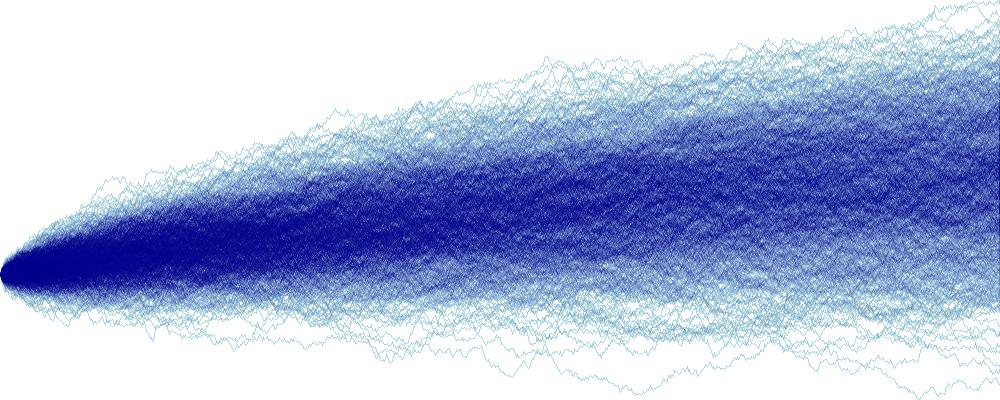

In [12]:
walks = pd.DataFrame(nn_sim_prices.T)

time = np.linspace(0, 1, walks.shape[1])
n = walks.shape[0]
points = walks.shape[1]

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(walks, 
               x=time,
               y=list(range(points)), 
               agg=ds.count(), 
               axis=1, 
               line_width=0)
img = tf.shade(agg, how='eq_hist')

img

# Distribution Plots

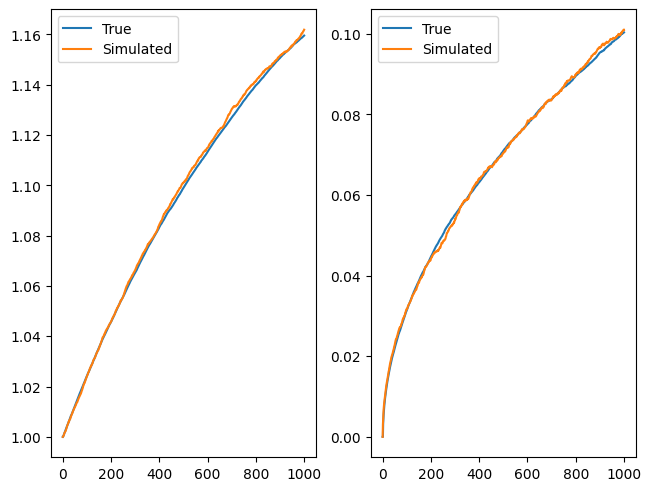

In [13]:
fig, ax = plt.subplots(1,2, constrained_layout=True)

ax[0].plot(val_sim_prices[:, :10_000].mean(axis=1), label='True')
ax[0].plot(nn_sim_prices.mean(axis=1), label='Simulated')
ax[0].legend()

ax[1].plot(val_sim_prices[:, :10_000].std(axis=1), label='True')
ax[1].plot(nn_sim_prices.std(axis=1), label='Simulated')
ax[1].legend()

plt.show()

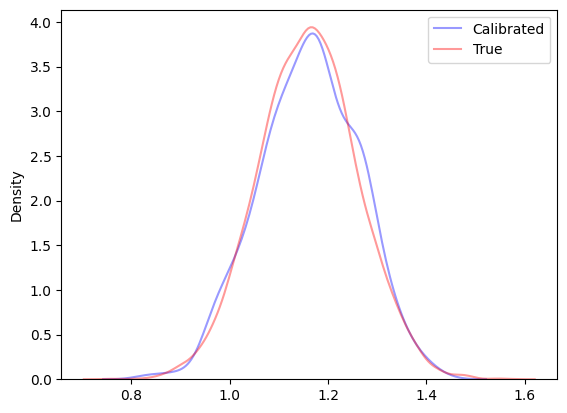

In [14]:
final_sim_prices = nn_sim_prices[-1]
final_val_sim_prices = val_sim_prices[-1]

sns.kdeplot(final_sim_prices, alpha=0.4, color='blue', label='Calibrated')
sns.kdeplot(final_val_sim_prices, alpha=0.4, color='red', label='True')
plt.legend()
plt.show()